The whole notebook takes around **60 seconds** to complete on a machine with Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz.

In [1]:
import itertools

import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm # progress bars

import peca

In [2]:
def exponential_ma_model(T, order):
    X = np.random.exponential(size=T)
    if order > 1:
        X = np.convolve(X, [1./order] * order, mode='same')
        X = (X-X.mean())/X.std() # standardize
        X = X-X.min() # make positive
    return X

# Figure 4
Canonical trigger coincidence processes and corresponding QTR plot,
for a simulated time series and two event series (independent and dependent).

In [3]:
# random data or data from paper?
random_data = False

if random_data:
    T = 4096
    Delta = 7
    N_E = 32
    order = 8
    shift = 4
    X = exponential_ma_model(T, order)
    E_ind = np.zeros(T)
    E_ind[np.random.choice(range(T-Delta), size=N_E, replace=False)] = 1
    E_dep = np.zeros(T)
    E_dep[np.random.choice(np.where(X>4)[0]-shift, size=N_E, replace=False)] = 1
else:
    # load data from the paper
    data = pd.read_csv("fig4.dat", sep=" ", index_col=0)
    X = data['X'].values
    E_ind = data['E'].values # independent
    E_dep = data['E_dep'].values # dependent
    T = len(X)
    N_E = E_dep.sum() # = E_ind.sum()

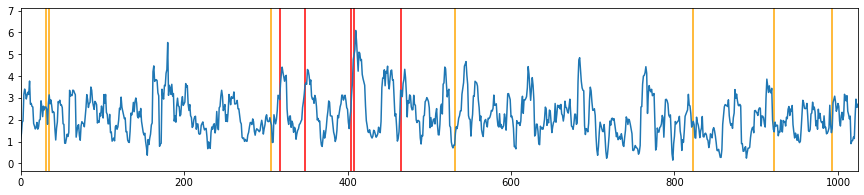

In [4]:
plt.figure(figsize=(15,3))
for i in np.where(E_ind==1)[0]:
    plt.axvline(i, c="orange")
for i in np.where(E_dep==1)[0]:
    plt.axvline(i, c="red")
plt.plot(X)
plt.xlim(0,1024)
plt.show()

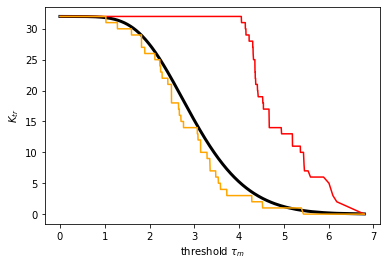

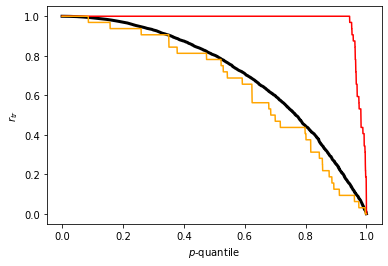

In [5]:
Delta = 7
taus = np.sort(X) # for canonical process

tcp_params = peca.tcp_params_fit(X, Delta, taus)
K_tr_ind = peca.tcp(X, E_ind, Delta, taus)
K_tr_dep = peca.tcp(X, E_dep, Delta, taus)

plt.plot(taus, peca.tcp_marginal_expectation(N_E, tcp_params), c="black", lw=3)
plt.plot(taus, K_tr_dep, c="red")
plt.plot(taus, K_tr_ind, c="orange")
plt.xlabel('threshold $\\tau_m$')
plt.ylabel('$K_{tr}$')
plt.show()

plt.plot(np.linspace(1,T,T)/T, peca.tcp_marginal_expectation(N_E, tcp_params)/N_E, c="black", lw=3)
plt.plot(np.linspace(1,T,T)/T, K_tr_dep/N_E, c="red")
plt.plot(np.linspace(1,T,T)/T, K_tr_ind/N_E, c="orange")
plt.xlabel("$p$-quantile")
plt.ylabel("$r_{tr}$")
plt.show()

# Figure 5
Expected QTR plots for simulated pairs of independent time series and event series, for three
different levels of serial dependencies (MA orders 0, 32, 128) and increasing time tolerance
($\Delta$ = 0, 1, 2, 4, 8, 16, 32, 64).

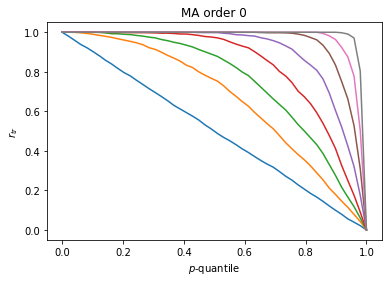

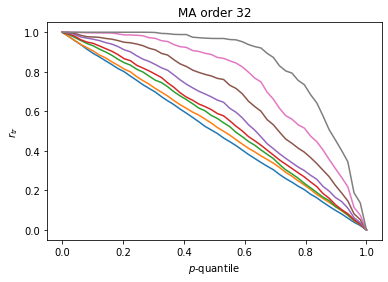

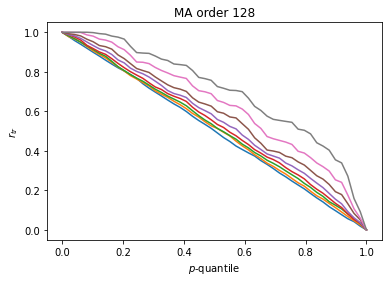

In [6]:
T = 4196
Deltas = [0,1,2,4,8,16,32,64]
rhos = np.linspace(0,1,50)
orders = [0,32,128]
N_E = 32
repetitions = 100

q_tr_vals = np.zeros((len(orders), len(Deltas), len(rhos)))
for i, order in enumerate(orders):
    X = exponential_ma_model(T, order)
    taus = np.percentile(X, rhos*100)
    for j, Delta in enumerate(Deltas):
        for rep in range(repetitions):
            E = np.zeros(T)
            E[np.random.choice(range(T-Delta), size=N_E, replace=False)] = 1
            q_tr_vals[i,j,:] += peca.tcp(X, E, Delta, taus)/float(N_E)
        q_tr_vals[i,j,:] /= repetitions
        plt.plot(rhos, q_tr_vals[i,j,:])
        plt.title("MA order %d" % order)
        plt.xlabel("$p$-quantile")
        plt.ylabel("$r_{tr}$")
    plt.show()

# Figure 7
Comparison of null distributions (Monte Carlo, Bernoulli, GEV) of the number of trigger coincidences under independence, for three time series with different MA orders, at three thresholds ($\tau$ = 3, 4, 5).

In [7]:
def simulate(T, order, N_E, taus, Deltas, samples):
    p_gevs = np.empty((len(taus), len(Deltas))) # success probabilities under GEV distribution (our work)
    p_bers = np.empty((len(taus), len(Deltas))) # success probabilities under Bernoulli assumption (previous work)
    K_triggers = np.zeros((len(taus), len(Deltas), samples))

    X = exponential_ma_model(T, order)
    for (itau, jDelta) in tqdm(list(itertools.product(enumerate(taus), enumerate(Deltas)))):
        i, tau = itau
        j, Delta = jDelta

        # obtain threshold exceedance process
        A = (X > tau)*1

        # estimate p under Bernoulli assumption
        N_A = A.sum()
        p_bers[i,j] = (1-(1-N_A/T)**(Delta+1))
        
        # estimate p under GEV distribution
        Mk = np.array([X[t:(t+Delta+1)].max() for t in range(0, T, Delta+1)])
        gev_params = ss.genextreme.fit(Mk)
        p_gevs[i,j] = (1-ss.genextreme.cdf(tau, *gev_params))
        
        # Monte Carlo estimate
        for s in range(samples):
            # sample independent event series with N_E events
            E = np.zeros(T)
            E[np.random.choice(range(T-Delta), size=N_E, replace=False)] = 1
            
            # record observed number of trigger coincidences
            K_trigger = len([t for t in range(T-Delta) if (E[t] == 1) and np.sum(A[t:t+Delta+1]) >= 1])
            K_triggers[i,j,s] = K_trigger
        
    return {
        "K_triggers" : K_triggers,
        "p_gevs" : p_gevs,
        "p_bers" : p_bers
    }

In [8]:
T = 8192
N_E = 32
taus = [5,4,3]
Deltas = [7]
samples = 1000

np.random.seed(2)
sim_ma0  = simulate(T=T, order= 0, N_E=N_E, taus=taus, Deltas=Deltas, samples=samples)
sim_ma32 = simulate(T=T, order=32, N_E=N_E, taus=taus, Deltas=Deltas, samples=samples)
sim_ma64 = simulate(T=T, order=64, N_E=N_E, taus=taus, Deltas=Deltas, samples=samples)

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


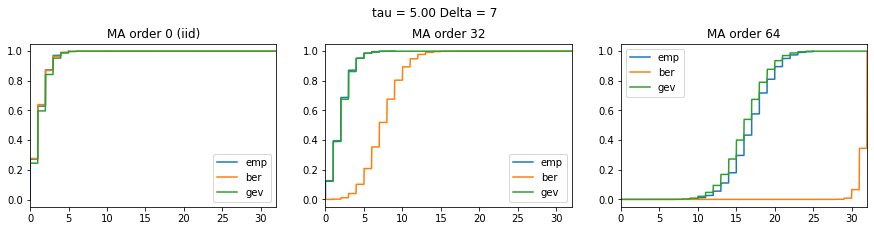

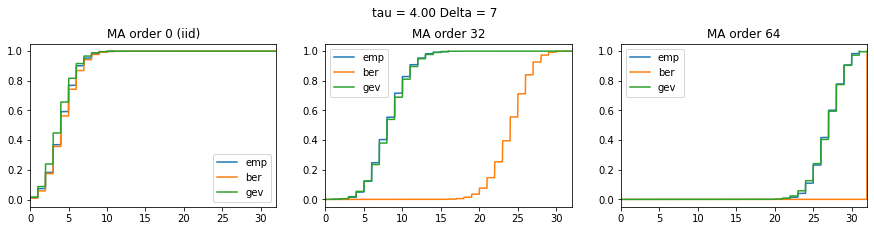

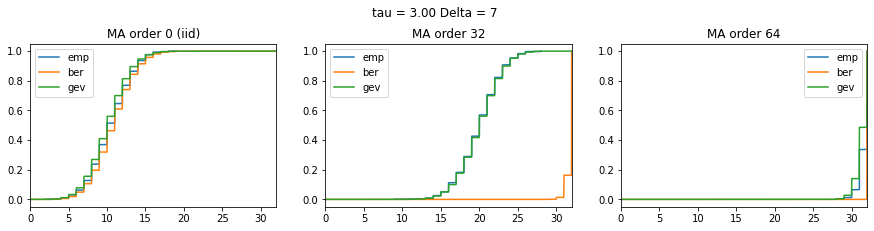

In [9]:
for i in range(len(taus)):
    for j in range(len(Deltas)):
        plt.figure(figsize=(15,3))
        plt.suptitle("tau = %.2f Delta = %d" % (taus[i], Deltas[j]), y=1.05)

        plt.subplot(131)
        plt.title("MA order 0 (iid)")
        plt.plot(np.sort(sim_ma0["K_triggers"][i,j]), (np.array(range(samples))+1)/samples, label="emp")
        plt.plot(np.linspace(0,N_E,1000), ss.binom.cdf(np.linspace(0,N_E,1000), N_E, sim_ma0["p_bers"][i,j]), label="ber")
        plt.plot(np.linspace(0,N_E,1000), ss.binom.cdf(np.linspace(0,N_E,1000), N_E, sim_ma0["p_gevs"][i,j]), label="gev")
        plt.xlim(0,N_E)
        plt.legend()

        plt.subplot(132)
        plt.title("MA order 32")
        plt.plot(np.sort(sim_ma32["K_triggers"][i,j]), (np.array(range(samples))+1)/samples, label="emp")
        plt.plot(np.linspace(0,N_E,1000), ss.binom.cdf(np.linspace(0,N_E,1000), N_E, sim_ma32["p_bers"][i,j]), label="ber")
        plt.plot(np.linspace(0,N_E,1000), ss.binom.cdf(np.linspace(0,N_E,1000), N_E, sim_ma32["p_gevs"][i,j]), label="gev")
        plt.xlim(0,N_E)
        plt.legend()

        plt.subplot(133)
        plt.title("MA order 64")
        plt.plot(np.sort(sim_ma64["K_triggers"][i,j]), (np.array(range(samples))+1)/samples, label="emp")
        plt.plot(np.linspace(0,N_E,1000), ss.binom.cdf(np.linspace(0,N_E,1000), N_E, sim_ma64["p_bers"][i,j]), label="ber")
        plt.plot(np.linspace(0,N_E,1000), ss.binom.cdf(np.linspace(0,N_E,1000), N_E, sim_ma64["p_gevs"][i,j]), label="gev")
        plt.xlim(0,N_E)
        plt.legend()

        plt.show()

# Figure 9
Simulated trigger coincidence processes under independence, colorized by their
surprise value, along with the theoretical minima and maxima.

In [10]:
T = 8192
N_E = 32
order = 8
Delta = 7
rhos = np.linspace(0.75,1,32)
idx_start = 0

X = exponential_ma_model(T, order)
E = np.zeros(T)
E[np.random.choice(range(T-Delta), size=N_E, replace=False)] = 1

taus = np.percentile(X,rhos*100)
tcp_params = peca.tcp_params_fit(X, Delta, taus)

### Simulate trigger coincidence processes from independent event series

In [11]:
simuls = 1000
simul_nlls = np.zeros(simuls)
simul_seqs = [None] * simuls
for s in tqdm(range(simuls)):
    simul_E = np.random.permutation(E)
    simul_K_vals = peca.tcp(X, simul_E, Delta, taus)
    simul_seqs[s] = simul_K_vals
    simul_nlls[s] = peca.tcp_nll(simul_K_vals, N_E, tcp_params)
simul_seqs = np.array(simul_seqs)

Widget Javascript not detected.  It may not be installed or enabled properly.


### Compute most likely and least likely trigger coincidence process from Markov model
... which corresponds to the highest and lowest possible test statistic values

In [12]:
# find the most likely TCP (DP algorithm)
Qmax = (-np.infty)*np.ones((N_E+1, len(rhos)))
Qmax[:,idx_start] = [ss.binom.logpmf(k, N_E, tcp_params[0][idx_start]) for k in range(0,N_E+1)]
Qargmax = (-1)*np.ones((N_E+1, len(rhos)), dtype="int")
for m in range(idx_start+1, len(rhos)):
    Qmax[:,m] = [np.max([Qmax[kprev,m-1] + ss.binom.logpmf(k, kprev, tcp_params[1][m])
            for kprev in range(k,N_E+1)])
        for k in range(0,N_E+1)]
    Qargmax[:,m] = [k+np.argmax([Qmax[kprev,m-1] + ss.binom.logpmf(k, kprev, tcp_params[1][m])
            for kprev in range(k,N_E+1)])
        for k in range(0,N_E+1)]
DPMode_q_tr_vals_proc = np.zeros_like(rhos)*np.nan
m = len(rhos)-1
k = np.argmax(Qmax[:,m])
while k >= 0:
    DPMode_q_tr_vals_proc[m] = k
    k = Qargmax[k,m]
    m = m-1

# plot path through DP table
#plt.imshow(Qmax)
#plt.plot(DPMode_q_tr_vals_proc)
#plt.show()

In [13]:
# find the least likely TCP (DP algorithm)
Qmin = np.infty*np.ones((N_E+1, len(rhos)))
Qmin[:,idx_start] = [ss.binom.logpmf(k, N_E, tcp_params[0][idx_start]) for k in range(0,N_E+1)]
Qargmin = (-1)*np.ones((N_E+1, len(rhos)), dtype="int")
for m in range(idx_start+1, len(rhos)):
    Qmin[:,m] = [np.min([Qmin[kprev,m-1] + ss.binom.logpmf(k, kprev, tcp_params[1][m])
            for kprev in range(k,N_E+1)])
        for k in range(0,N_E+1)]
    Qargmin[:,m] = [k+np.argmin([Qmin[kprev,m-1] + ss.binom.logpmf(k, kprev, tcp_params[1][m])
            for kprev in range(k,N_E+1)])
        for k in range(0,N_E+1)]
DPAntiMode_q_tr_vals_proc = np.zeros_like(rhos)*np.nan
m = len(rhos)-1
k = np.argmin(Qmin[:,m])
while k >= 0:
    DPAntiMode_q_tr_vals_proc[m] = k
    k = Qargmin[k,m]
    m = m-1

# plot path through DP table
#plt.imshow(Qmin)
#plt.plot(DPAntiMode_q_tr_vals_proc)
#plt.show()

### Plot everything

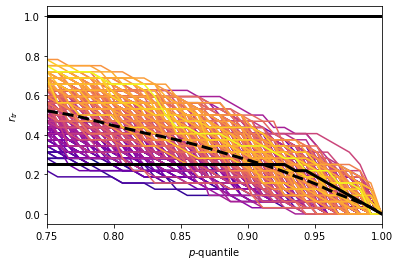

In [14]:
cmap = plt.get_cmap('plasma')

simul_seqs2 = simul_seqs[np.argsort(simul_nlls)].copy()
simul_nlls2 = simul_nlls.copy()
simul_nlls2.sort()

for seq, nll in zip(simul_seqs2, simul_nlls2):
    plt.plot(rhos, seq/N_E, color=cmap((nll-simul_nlls2.min())/(simul_nlls2.max()-simul_nlls2.min())), alpha=1)
plt.plot(rhos, DPMode_q_tr_vals_proc/N_E, "k-", lw=3, alpha=1) # most likely TCP / lowest possible test statistic value
plt.plot(rhos, DPAntiMode_q_tr_vals_proc/N_E, "k-", lw=3, alpha=1) # least likely TCP / highest possible test statistic value
plt.plot(rhos, peca.tcp_marginal_expectation(N_E, tcp_params)/N_E, "k--", lw=3, alpha=1)
plt.xlabel('$p$-quantile')
plt.ylabel('$r_{tr}$')
plt.xlim((rhos[idx_start],1))
plt.show()